In [1]:
# Import necessary modules and functions

import pandas as pd
import seaborn as sns
import numpy as np
import nltk
import spacy
import datetime

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 8


from scipy.stats import norm
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import datasets
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.decomposition import IncrementalPCA
from sklearn.neural_network import MLPClassifier

#nltk.download('vader_lexicon') #uncomment and download 1 time

import warnings
warnings.filterwarnings('ignore')

kaggledf = pd.read_csv('KS_train_data.csv', delimiter = ',')
kaggletestdf = pd.read_csv('KS_test_data.csv', delimiter = ';')

Adjust Colums

In [2]:
train_purpose = ["pledged","funded"]
test_columns = ["project_id", "blurb", "category", "country", "created_at", "currency", "deadline", "fx_rate", "goal", "launched_at", "name", "staff_pick", "location", "subcategory", "project_url"]

test_columns += train_purpose

#drop colums that are not in test_set + reward URL
kaggledf = kaggledf.drop(columns=[col for col in kaggledf if col not in test_columns])
kaggledf.dropna(inplace=True)

In [3]:
###url extraction for training data
pd.set_option('display.max_colwidth', None)
#borrowed Nick's efficient method
url_split = []
for url in kaggledf['project_url']:
       url = url.split('/')[-1]
       url_split.append(url.replace('-',' '))

kaggledf['project_url_split'] = url_split
cols=['project_url','project_url_split']
kaggledf[cols]


,project_url,project_url_split
0,https://www.kickstarter.com/projects/hilaryemersonlay/elsewhere-studios-artist-in-residency-program,elsewhere studios artist in residency program
1,https://www.kickstarter.com/projects/17146650/1000-artists-presidential-inauguration-2013,1000 artists presidential inauguration 2013
2,https://www.kickstarter.com/projects/belveal/myphonehenge,myphonehenge
3,https://www.kickstarter.com/projects/1078130915/walk-through,walk through
4,https://www.kickstarter.com/projects/1044092769/a-kitchen-for-habitable-spaces,a kitchen for habitable spaces
...,...,...
99995,https://www.kickstarter.com/projects/jimmycarbone/help-fund-the-back-room-arts-space-at-jimmys-no-43,help fund the back room arts space at jimmys no 43
99996,https://www.kickstarter.com/projects/rvacomedy/the-coalition-theater-0,the coalition theater 0
99997,https://www.kickstarter.com/projects/1601712092/the-voix-de-ville-a-pop-up-theater-and-cabaret,the voix de ville a pop up theater and cabaret
99998,https://www.kickstarter.com/projects/967829854/save-the-studio,save the studio


In [4]:
###url extraction for test data

pd.set_option('display.max_colwidth', None)
#borrowed Nick's efficient method
url_split_test = []
for url in kaggletestdf['project_url']:
       url = url.split('/')[-1]
       url_split_test.append(url.replace('-',' '))

kaggletestdf['project_url_split'] = url_split_test
cols=['project_url','project_url_split']
kaggletestdf.dropna(inplace=True)
kaggletestdf[cols]

,project_url,project_url_split
0,https://www.kickstarter.com/projects/1536850207/martin-luther-king-jr-sculpture-on-campus,martin luther king jr sculpture on campus
1,https://www.kickstarter.com/projects/2039713907/emergence-surreal-oil-paintings-by-jj-long,emergence surreal oil paintings by jj long
2,https://www.kickstarter.com/projects/1442314751/pmaftw,pmaftw
3,https://www.kickstarter.com/projects/199636585/metropolove-book-project-to-be-completed-from-2010,metropolove book project to be completed from 2010
4,https://www.kickstarter.com/projects/jimgroom/ds106-the-open-online-community-of-digital-storyte,ds106 the open online community of digital storyte
...,...,...
78060,https://www.kickstarter.com/projects/552677239/improvmania-improv-comedy-theater-chandler-arizona,improvmania improv comedy theater chandler arizona
78061,https://www.kickstarter.com/projects/1947692763/build-the-house-of-dads,build the house of dads
78062,https://www.kickstarter.com/projects/1365853422/the-pocket-theater-seattle-needs-a-place-to-perfor,the pocket theater seattle needs a place to perfor
78063,https://www.kickstarter.com/projects/schmeater/shelter-the-schmee,shelter the schmee


In [5]:
####Tf/IDF for url extractions for the top 100 words (can change this later)
vect = TfidfVectorizer(analyzer='word', stop_words='english', max_features = 100)
#perform tf/idf on training data
X = vect.fit_transform(kaggledf['project_url_split'])
#convert into a dataframe
X_df = pd.DataFrame(data = X.A, columns=vect.get_feature_names(), index=kaggledf.index)
#perform tf/idf on test data
X_test = vect.transform(kaggletestdf['project_url_split'])
#convert into a dataframe
X_testdf = pd.DataFrame(data = X_test.A, columns=vect.get_feature_names(), index=kaggletestdf.index)
pd.set_option('display.max_columns', None)
#add the new columns/features to training and test datasets
kaggledf = kaggledf.join(X_df)
kaggletestdf = kaggletestdf.join(X_testdf)
kaggledf


,project_id,blurb,category,country,created_at,currency,deadline,fx_rate,goal,launched_at,name,pledged,staff_pick,location,funded,subcategory,project_url,project_url_split,100,2015,3d,adventure,album,american,animated,app,art,artist,big,black,book,bring,calendar,card,cards,cd,childrens,city,coffee,collection,comedy,comic,community,company,dance,day,debut,design,documentary,dream,edition,ep,fantasy,farm,feature,festival,film,food,free,fund,game,graphic,hand,help,high,home,horror,house,issue,journey,kids,la,length,lets,life,light,little,live,love,magazine,make,making,man,mobile,movie,music,musical,new,novel,open,original,photo,photography,play,playing,presents,print,production,project,record,recording,release,season,series,short,smart,space,stories,story,studio,time,tour,truck,video,volume,web,world,worlds
0,KS_000000,"I will be an artist-in-residence at Elsewhere Studios this summer, where I will stretch my wings and see where I land!",art,US,1325980505,USD,1334866560,1.000000,2800.0,1332969260,Elsewhere Studios artist-in-residency program!,3596.00,False,"Paonia, CO",True,mixed media,https://www.kickstarter.com/projects/hilaryemersonlay/elsewhere-studios-artist-in-residency-program,elsewhere studios artist in residency program,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,KS_000001,1000 Artists is a public art-making installation on the Washington Mall which will occur on January 21 and 22nd 2013.,art,US,1330926084,USD,1336440145,1.000000,4500.0,1332984145,1000 Artists: Presidential Inauguration 2013,4586.00,False,"Washington, DC",True,public art,https://www.kickstarter.com/projects/17146650/1000-artists-presidential-inauguration-2013,1000 artists presidential inauguration 2013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,KS_000002,"The Sequel to ‘My Favorite Machine”, ""MyPhoneHenge"" celebrates Community across Virtual and Real Worlds.",art,US,1332382894,USD,1338175739,1.000000,5000.0,1332991739,MyPhoneHenge,5217.00,False,"Frisco, TX",True,sculpture,https://www.kickstarter.com/projects/belveal/myphonehenge,myphonehenge,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,KS_000003,A film exploring the role and value of art education today through the history of the seminal California Institute of the Arts.,art,GB,1332342451,USD,1334806096,1.000000,6500.0,1332991696,Walk-Through,7160.00,False,"Glasgow, UK",True,art,https://www.kickstarter.com/projects/1078130915/walk-through,walk through,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,KS_000004,"We need to build a kitchen for Habi

In [6]:
####Tf/IDF for blurb extractions for the top 100 words (can change this later)
vect_blurb = TfidfVectorizer(analyzer='word', stop_words='english', max_features = 100)
#convert blurbs into unicode data type
Xblurb = kaggledf['blurb'].values.astype('U')
Xblurb_test = kaggletestdf['blurb'].values.astype('U')
#perform td/idf on training data
Xblurb = vect_blurb.fit_transform(Xblurb)
#convert into a dataframe
Xblurb_df = pd.DataFrame(data = Xblurb.A, columns=vect_blurb.get_feature_names(), index=kaggledf.index)
#perform tf/idf on test data
Xblurb_test = vect_blurb.transform(Xblurb_test)
#convert into a dataframe
Xblurb_testdf = pd.DataFrame(data = Xblurb_test.A, columns=vect_blurb.get_feature_names(), index=kaggletestdf.index)
pd.set_option('display.max_columns', None)
vect_blurb.get_feature_names()
#find the different column names (or words) so there are no duplicate columns between the words selected 
#from the url and the blurbs
cols_to_use = Xblurb_df.columns.difference(kaggledf.columns)
#add the new columns/features to training and test datasets
#this ends up adding 44 new columns instead of 100 since there were a lot of overlapping words from the url data
kaggledf = kaggledf.join(Xblurb_df[cols_to_use])
kaggletestdf = kaggletestdf.join(Xblurb_testdf[cols_to_use])
kaggledf

,project_id,blurb,category,country,created_at,currency,deadline,fx_rate,goal,launched_at,name,pledged,staff_pick,location,funded,subcategory,project_url,project_url_split,100,2015,3d,adventure,album,american,animated,app,art,artist,big,black,book,bring,calendar,card,cards,cd,childrens,city,coffee,collection,comedy,comic,community,company,dance,day,debut,design,documentary,dream,edition,ep,fantasy,farm,feature,festival,film,food,free,fund,game,graphic,hand,help,high,home,horror,house,issue,journey,kids,la,length,lets,life,light,little,live,love,magazine,make,making,man,mobile,movie,music,musical,new,novel,open,original,photo,photography,play,playing,presents,print,production,project,record,recording,release,season,series,short,smart,space,stories,story,studio,time,tour,truck,video,volume,web,world,worlds,artists,band,based,beautiful,best,build,children,create,creating,designed,experience,family,featuring,friends,fun,great,inspired,just,like,local,looking,money,need,needs,old,people,quality,real,set,share,small,songs,support,unique,use,using,ve,want,way,women,work,year,years,young
0,KS_000000,"I will be an artist-in-residence at Elsewhere Studios this summer, where I will stretch my wings and see where I land!",art,US,1325980505,USD,1334866560,1.000000,2800.0,1332969260,Elsewhere Studios artist-in-residency program!,3596.00,False,"Paonia, CO",True,mixed media,https://www.kickstarter.com/projects/hilaryemersonlay/elsewhere-studios-artist-in-residency-program,elsewhere studios artist in residency program,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,KS_000001,1000 Artists is a public art-making installation on the Washington Mall which will occur on January 21 and 22nd 2013.,art,US,1330926084,USD,1336440145,1.000000,4500.0,1332984145,1000 Artists: Presidential Inauguration 2013,4586.00,False,"Washington, DC",True,public art,https://www.kickstarter.com/projects/17146650/1000-artists-presidential-inauguration-2013,1000 artists presidential inauguration 2013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.630286,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,KS_000002,"The Sequel to ‘My Favorite Machine”, ""MyPhoneHenge"" celebrates Community across Virtual and Real Worlds.",art,US,1332382894,USD,1338175739,1.000000,5000.0,1332991739,MyPhoneHenge,5217.00,False,"Frisco, TX",True,sculpture,https://www.kickstarter.com/projects/belveal/myphonehenge,myphonehenge,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [7]:
#nltk.download('vader_lexicon', quiet=False) # you can download 1 time then comment out
from nltk.sentiment.vader import SentimentIntensityAnalyzer #verify download
vader_model = SentimentIntensityAnalyzer()

In [8]:
nlp = spacy.load('en_core_web_sm') # en_core_web_sm

---------------------

# Time Operations

In [9]:
#calculate seconds from UNIX timestamp
kaggledf["seconds"] = kaggledf["deadline"] - kaggledf["created_at"]
kaggletestdf["seconds"] = kaggletestdf["deadline"] - kaggletestdf["created_at"]

In [10]:
#log transform time columns

time_cols = ["seconds","deadline","created_at","launched_at"]
for col in time_cols:
    kaggledf[col] = np.log(kaggledf[col])
    kaggletestdf[col] = np.log(kaggletestdf[col])


# Currency Operations

In [11]:
#convert all goals to USD
kaggledf["goal"] = kaggledf["goal"] * kaggledf["fx_rate"]
kaggletestdf["goal"] = kaggletestdf["goal"] * kaggletestdf["fx_rate"]


kaggledf["pledged"] = kaggledf["pledged"] * kaggledf["fx_rate"]


#delete unnessesary colums
kaggledf = kaggledf.drop(columns=["fx_rate", "currency"])
kaggletestdf = kaggletestdf.drop(columns=["fx_rate", "currency"])


# Categorial Data to Numerical 

In [12]:
#categorical to numerical data

dummy_category_train = pd.get_dummies(kaggledf['category'], prefix = "category_")
dummy_category_test = pd.get_dummies(kaggletestdf['category'], prefix = "category_")

#dummy_subcategory = pd.get_dummies(kaggledf['subcategory'], prefix = "subcategory_")
#dummy_country = pd.get_dummies(kaggledf['country'], prefix = "country_")

kaggledf = pd.merge(left=kaggledf, right=dummy_category_train,left_index=True,right_index=True)
kaggletestdf = pd.merge(left=kaggletestdf, right=dummy_category_test,left_index=True,right_index=True)

#kaggledf = pd.merge(left=kaggledf, right=dummy_subcategory,left_index=True,right_index=True)
#kaggledf = pd.merge(left=kaggledf, right=dummy_country,left_index=True,right_index=True)

kaggledf = kaggledf.drop(columns = ["category","subcategory","country"])
kaggletestdf = kaggletestdf.drop(columns = ["category","subcategory","country"])

kaggledf["staff_pick"] = kaggledf["staff_pick"].apply(lambda x: 1 if x == True else 0)
kaggletestdf["staff_pick"] = kaggletestdf["staff_pick"].apply(lambda x: 1 if x == True else 0)

#change funded to numerical if in df
kaggledf["funded"] = kaggledf["funded"].apply(lambda x: 1 if x == True else 0)


In [13]:
pd.set_option("display.max_rows", 10, "display.max_columns", None)
#categorical ranges for goal and pledged, sentiment vader (numerical & categorical)  
#columns to be removed: url's, location, id,
kaggledf

,project_id,blurb,created_at,deadline,goal,launched_at,name,pledged,staff_pick,location,funded,project_url,project_url_split,100,2015,3d,adventure,album,american,animated,app,art,artist,big,black,book,bring,calendar,card,cards,cd,childrens,city,coffee,collection,comedy,comic,community,company,dance,day,debut,design,documentary,dream,edition,ep,fantasy,farm,feature,festival,film,food,free,fund,game,graphic,hand,help,high,home,horror,house,issue,journey,kids,la,length,lets,life,light,little,live,love,magazine,make,making,man,mobile,movie,music,musical,new,novel,open,original,photo,photography,play,playing,presents,print,production,project,record,recording,release,season,series,short,smart,space,stories,story,studio,time,tour,truck,video,volume,web,world,worlds,artists,band,based,beautiful,best,build,children,create,creating,designed,experience,family,featuring,friends,fun,great,inspired,just,like,local,looking,money,need,needs,old,people,quality,real,set,share,small,songs,support,unique,use,using,ve,want,way,women,work,year,years,young,seconds,category__art,category__comics,category__crafts,category__dance,category__design,category__fashion,category__film & video,category__food,category__games,category__journalism,category__music,category__photography,category__publishing,category__technology,category__theater
0,KS_000000,"I will be an artist-in-residence at Elsewhere Studios this summer, where I will stretch my wings and see where I land!",21.005418,21.012097,2800.000000,21.010675,Elsewhere Studios artist-in-residency program!,3596.000000,0,"Paonia, CO",1,https://www.kickstarter.com/projects/hilaryemersonlay/elsewhere-studios-artist-in-residency-program,elsewhere studios artist in residency program,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.999994,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,KS_000001,1000 Artists is a public art-making installation on the Washington Mall which will occur on January 21 and 22nd 2013.,21.009141,21.013275,4500.000000,21.010686,1000 Artists: Presidential Inauguration 2013,4586.000000,0,"Washington, DC",1,https://www.kickstarter.com/projects/17146650/1000-artists-presidential-inauguration-2013,1000 artists presidential inauguration 2013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.630286,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.522812,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,KS_000002,"The Sequel to ‘My Favorite Machine”, ""MyPhoneHenge"" celebrates Community across Virtual and Real Worlds.",21.010235,21.014573,5000.000000,21.010692,MyPhoneHenge,5217.000000,0,"Frisco, TX",1,https://www.kickstarter.com/projects/belveal/myphonehenge,myphonehenge,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

# Data Exploration

<AxesSubplot:>

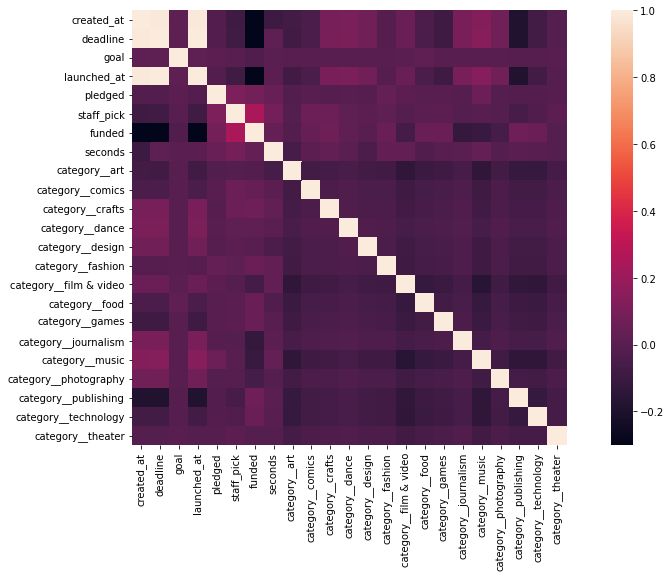

In [127]:
corr_cols = ["created_at","pledged","staff_pick","funded","seconds","goal","category__art","category__comics","category__crafts","category__dance","category__design","category__fashion","category__film & video","category__food","category__games","category__journalism","category__music","category__photography","category__publishing","category__technology","category__theater"]

corrmat = kaggledf.corr()
sns.heatmap(corrmat, square=True, annot=False)

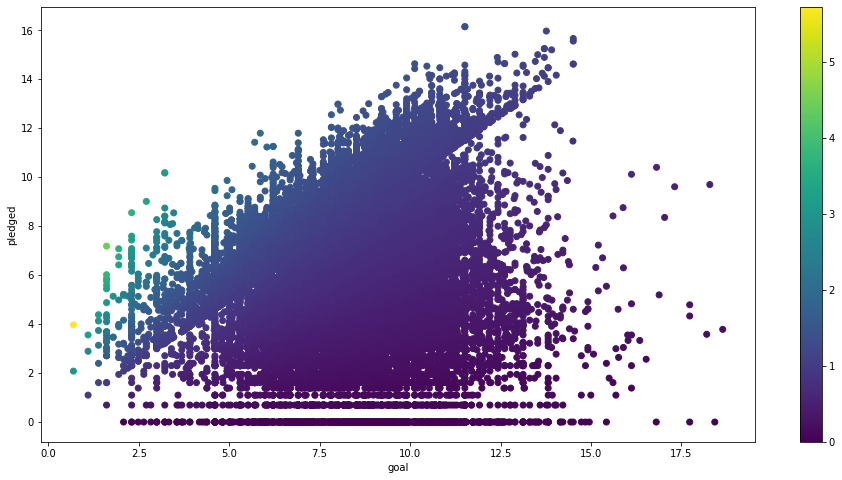

In [128]:
plt.figure()

goal = np.log(kaggledf["goal"].astype(int))
pledged = np.log(kaggledf["pledged"].astype(int))
c = pledged/goal



for i, num in enumerate(c):
    if num == math.inf or num > 12:
        c.drop(i, inplace = True)
        goal.drop(i, inplace = True)
        pledged.drop(i, inplace = True)


plt.scatter(goal, pledged, c = c)
plt.xlabel("goal")
plt.ylabel("pledged")
plt.colorbar()

Logistic Regression

In [79]:
reg_cols = ['created_at', 'deadline', 'goal', 'launched_at', 'staff_pick', 'seconds',
       'category__art', 'category__comics', 'category__crafts',
       'category__dance', 'category__design', 'category__fashion',
       'category__film & video', 'category__food', 'category__games',
       'category__journalism', 'category__music', 'category__photography',
       'category__publishing', 'category__technology', 'category__theater']

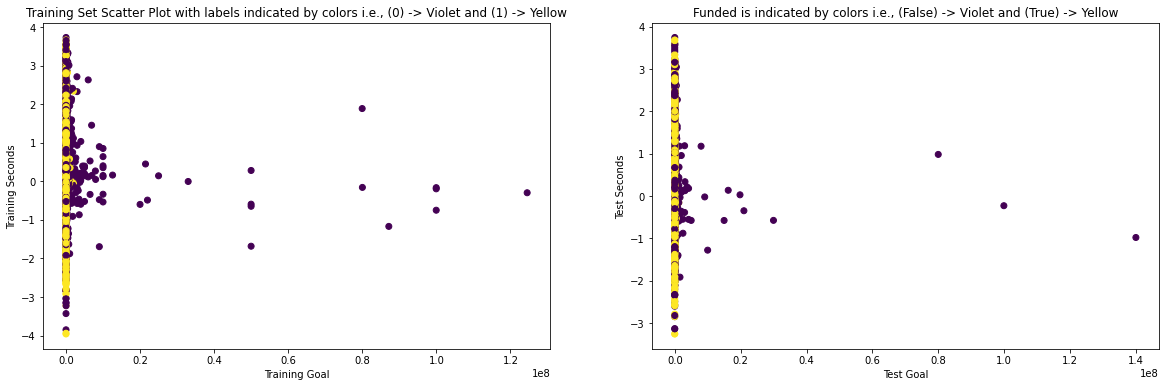

0.7106624993595327

In [135]:
x_train, x_test, y_train, y_test = train_test_split(kaggledf[reg_cols], kaggledf["funded"], test_size=0.25, random_state=0)


pca = IncrementalPCA(n_components = 2)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.scatter(x_train_pca[:,0], x_train_pca[:,1], c = y_train)
plt.xlabel('Training Goal')
plt.ylabel('Training Seconds')
plt.title('Training Set Scatter Plot with labels indicated by colors i.e., (0) -> Violet and (1) -> Yellow')
plt.subplot(1, 2, 2)
plt.scatter(x_test_pca[:,0], x_test_pca[:,1], c = y_test)
plt.xlabel('Test Goal')
plt.ylabel('Test Seconds')
plt.title('Funded is indicated by colors i.e., (False) -> Violet and (True) -> Yellow')
plt.show()

LRG = linear_model.LogisticRegression(random_state = 0, solver="newton-cg").fit(x_train, y_train)
LRG.score(x_test, y_test)




In [134]:
#Logistic Reg on Test Data

predictions = LRG.predict(kaggletestdf[reg_cols])
kaggletestdf["LRG_pred_funded"] = predictions

kaggletestdf

,project_id,blurb,created_at,deadline,goal,launched_at,name,staff_pick,location,project_url,reward_url,project_url_split,seconds,category__art,category__comics,category__crafts,category__dance,category__design,category__fashion,category__film & video,category__food,category__games,category__journalism,category__music,category__photography,category__publishing,category__technology,category__theater,pred_funded
0,KS_100000,We are looking to bring a Visiting Sculptor from the Ivory Coast to work with our students to create a sculpture of MLK for our campus.,21.008992,21.012167,3900.0,21.010677,Martin Luther King Jr. Sculpture on Campus!,0,"Bakersfield, CA",https://www.kickstarter.com/projects/1536850207/martin-luther-king-jr-sculpture-on-campus,https://www.kickstarter.com/projects/1536850207/martin-luther-king-jr-sculpture-on-campus/rewards,martin luther king jr sculpture on campus,15.258241,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,KS_100001,Surrealistic oil paintings capturing the metamorphosis of organic forms springing to life.,21.010397,21.011924,750.0,21.010680,EMERGENCE: Surreal Oil Paintings by J.J. Long,0,"Lowell, MA",https://www.kickstarter.com/projects/2039713907/emergence-surreal-oil-paintings-by-jj-long,https://www.kickstarter.com/projects/2039713907/emergence-surreal-oil-paintings-by-jj-long/rewards,emergence surreal oil paintings by jj long,14.526779,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,KS_100002,P.M.A.F.T.W. my upcoming solo show June 2012 at Land Gallery.,21.010305,21.011014,1000.0,21.010690,P.M.A.F.T.W.,0,"Portland, OR",https://www.kickstarter.com/projects/1442314751/pmaftw,https://www.kickstarter.com/projects/1442314751/pmaftw/rewards,pmaftw,13.759190,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,KS_100003,A series of images about the art/artist and love on the playa at Burning Man. To be in book form. Quotes from all the artist included.,21.006592,21.014615,15000.0,21.010733,MetropoLOVE - Book project to be completed from 2010,0,"Imlay, NV",https://www.kickstarter.com/projects/199636585/metropolove-book-project-to-be-completed-from-2010,https://www.kickstarter.com/projects/199636585/metropolove-book-project-to-be-completed-from-2010/rewards,metropolove book project to be completed from 2010,16.185089,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,KS_100004,Become a part of the first crowd-funded community-driven open online course on digital storytelling.,21.010477,21.011902,4200.0,21.010735,DS106: The Open Online Community of Digital Storytellers,1,"Fredericksburg, VA",https://www.kickstarter.com/projects/jimgroom/ds106-the-open-online-community-of-digital-storyte,https://www.kickstarter.com/projects/jimgroom/ds106-the-open-online-community-of-digital-storyte/rewards,ds106 the open online community of digital storyte,14.457823,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78060,KS_178060,"Your opportunity to help improvMANIA open Chandler, Arizona's new home for family-friendly improv comedy in Historic Downtown Chandler!",21.063587,21.067086,7900.0,21.065283,"improvMANIA Improv Comedy Theater - Chandler, Arizona",0,"Chandler, AZ",https://www.kickstarter.com/projects/552677239/improvmania-improv-comedy-theater-chandler-arizona,https://www.kickstarter.com/projects/552677239/improvmania-improv-comedy-theater-chandler-arizona/rewards,improvmania improv comedy theater chandler arizona,15.409891,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
78061,KS_178061,"Dad's Garage Theatre Company needs your help buying our new, forever home by hitting our $150,000 STRETCH GOAL!",21.066748,21.070906,116000.0,21.067235,Build the House of Dad's!,1,"Atlanta, GA",https://www.kickstarter.com/projects/1947692763/build-the-house-of-dads,https://www.kickstarter.com/projects/1947692763/build-the-house-of-dads/rewards,build the house of dads,15.586081,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
78062,KS_178062,"A new performance space in Seattle. A place for artists, comedians, and audiences 

---------------------------

In [14]:
def run_vader(textual_unit, 
              lemmatize=False, 
              parts_of_speech_to_consider=set(),
              verbose=0):
    """
    Run VADER on a sentence from spacy
    
    :param str textual unit: a textual unit, e.g., sentence, sentences (one string)
    (by looping over doc.sents)
    :param bool lemmatize: If True, provide lemmas to VADER instead of words
    :param set parts_of_speech_to_consider:
    -empty set -> all parts of speech are provided
    -non-empty set: only these parts of speech are considered
    :param int verbose: if set to 1, information is printed
    about input and output
    
    :rtype: dict
    :return: vader output dict
    """
    doc = nlp(textual_unit)
        
    input_to_vader = []

    for sent in doc.sents:
        for token in sent:

            to_add = token.text
            

            if lemmatize:
                to_add = token.lemma_

                if to_add == '-PRON-': 
                    to_add = token.text

            if parts_of_speech_to_consider:
                if token.pos_ in parts_of_speech_to_consider:
                    input_to_vader.append(to_add) 
            else:
                input_to_vader.append(to_add)

    scores = vader_model.polarity_scores(' '.join(input_to_vader))
    
    if verbose >= 1:
        print()
        print('INPUT SENTENCE', sent)
        print('INPUT TO VADER', input_to_vader)
        print('VADER OUTPUT', scores)

    return scores

In [15]:
sentences = ["Here are my sentences.",
             "It's a nice day.",
             "It's a rainy day."]

for sent in sentences:
    scores = vader_model.polarity_scores(sent)
    print()
    print('INPUT SENTENCE', sent)
    print('VADER OUTPUT', scores)


INPUT SENTENCE Here are my sentences.
VADER OUTPUT {'neg': 0.0, 'neu': 0.714, 'pos': 0.286, 'compound': 0.0516}

INPUT SENTENCE It's a nice day.
VADER OUTPUT {'neg': 0.0, 'neu': 0.417, 'pos': 0.583, 'compound': 0.4215}

INPUT SENTENCE It's a rainy day.
VADER OUTPUT {'neg': 0.394, 'neu': 0.606, 'pos': 0.0, 'compound': -0.0772}


In [16]:
run_vader(sentences[2], lemmatize=True)

{'neg': 0.302, 'neu': 0.698, 'pos': 0.0, 'compound': -0.0772}

In [17]:
sent_input = kaggledf['blurb'][5]
print(sent_input)

Source Material is 2 person exhibition of the paintings of Brian Dupont and Chris Rusak at the Skydive Artspace in Houston, Texas.


In [18]:
run_vader(kaggledf['blurb'][56], lemmatize=True)


{'neg': 0.0, 'neu': 0.759, 'pos': 0.241, 'compound': 0.6908}

In [19]:
kaggledf['blurb']

0                        I will be an artist-in-residence at Elsewhere Studios this summer, where I will stretch my wings and see where I land!
1                         1000 Artists is a public art-making installation on the Washington Mall which will occur on January 21 and 22nd 2013.
2                                      The Sequel to ‘My Favorite Machine”, "MyPhoneHenge" celebrates Community across Virtual and Real Worlds.
3               A film exploring the role and value of art education today through the history of the seminal California Institute of the Arts.
4                            We need to build a kitchen for Habitable Spaces,  a self sustaining farm and artist residency on a ranch in Texas.
                                                                          ...                                                                  
99995                                                            Make the workshop/ small stage space at Jimmy's No 43 even better than 

In [20]:
sentiment_scores = []
for i, sentence in enumerate(kaggledf['blurb']):
    try:
        sentiment_scores.append(run_vader(sentence, lemmatize=True)['compound'])
    except:
        print(kaggledf['blurb'][i])

In [21]:
kaggledf['blurb_sentiment_scores'] = sentiment_scores

In [22]:
kaggledf['blurb_sentiment_scores']

0        0.0000
1        0.0000
2        0.7717
3        0.3400
4        0.0000
          ...  
99995   -0.1007
99996    0.7430
99997    0.4199
99998    0.9184
99999    0.0000
Name: blurb_sentiment_scores, Length: 99995, dtype: float64

In [23]:
test_sentiment_scores = []
for i, sentence in enumerate(kaggletestdf['blurb']):
    try:
        test_sentiment_scores.append(run_vader(sentence, lemmatize=True)['compound'])
        if i % 10000 == 0:
            print(i)
    except:
        print(kaggletestdf['blurb'][i])

0
10000
20000
30000
40000
50000
60000
70000


In [24]:
kaggletestdf['blurb_sentiment_scores'] = test_sentiment_scores

In [27]:
kaggletestdf['blurb_sentiment_scores']

0        0.2732
1        0.0000
2        0.0000
3        0.6369
4        0.0000
          ...  
78060    0.8883
78061    0.4574
78062    0.4389
78063    0.0000
78064    0.0000
Name: blurb_sentiment_scores, Length: 78060, dtype: float64

In [31]:
drop_columns = ['name', 'blurb', 'pledged', 'project_id', 'location', 'project_url', 'project_url_split']
kaggledf.drop(columns=drop_columns, inplace=True)

KeyError: "['name' 'blurb' 'pledged' 'project_id' 'location' 'project_url'] not found in axis"

In [57]:
#kaggledf.drop(columns=['project_url_split'], inplace=True)
pd.set_option('display.max_columns', None)
kaggledf

,created_at,deadline,goal,launched_at,staff_pick,funded,100,2015,3d,adventure,album,american,animated,app,art,artist,big,black,book,bring,calendar,card,cards,cd,childrens,city,coffee,collection,comedy,comic,community,company,dance,day,debut,design,documentary,dream,edition,ep,fantasy,farm,feature,festival,film,food,free,fund,game,graphic,hand,help,high,home,horror,house,issue,journey,kids,la,length,lets,life,light,little,live,love,magazine,make,making,man,mobile,movie,music,musical,new,novel,open,original,photo,photography,play,playing,presents,print,production,project,record,recording,release,season,series,short,smart,space,stories,story,studio,time,tour,truck,video,volume,web,world,worlds,artists,band,based,beautiful,best,build,children,create,creating,designed,experience,family,featuring,friends,fun,great,inspired,just,like,local,looking,money,need,needs,old,people,quality,real,set,share,small,songs,support,unique,use,using,ve,want,way,women,work,year,years,young,seconds,category__art,category__comics,category__crafts,category__dance,category__design,category__fashion,category__film & video,category__food,category__games,category__journalism,category__music,category__photography,category__publishing,category__technology,category__theater,blurb_sentiment_scores
0,21.005418,21.012097,2800.000000,21.010675,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.999994,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000
1,21.009141,21.013275,4500.000000,21.010686,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.630286,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.522812,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000
2,21.010235,21.014573,5000.000000,21.010692,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.74012,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.572134,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.7717
3,21.010204,21.012052,6500.000000,21.010692,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000

In [82]:
mlp_gs = MLPClassifier(max_iter=300)
parameter_space = {
    'hidden_layer_sizes': [(42,21,10),(21,10), (100,)],
    'activation': ['identity', 'relu'],
    'solver': ['adam'],
    'alpha': [0.05, 0.001],
    'learning_rate': ['constant']}
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=3, verbose=10)
X = kaggledf.loc[:, kaggledf.columns != 'funded']
y = kaggledf['funded']
clf.fit(X,y)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3, estimator=MLPClassifier(max_iter=300), n_jobs=-1,
             param_grid={'activation': ['identity', 'relu'],
                         'alpha': [0.05, 0.001],
                         'hidden_layer_sizes': [(42, 21, 10), (21, 10), (100,)],
                         'learning_rate': ['constant'], 'solver': ['adam']},
             verbose=10)

0.6852674106964278

,created_at,deadline,goal,launched_at,staff_pick,funded,100,2015,3d,adventure,album,american,animated,app,art,artist,big,black,book,bring,calendar,card,cards,cd,childrens,city,coffee,collection,comedy,comic,community,company,dance,day,debut,design,documentary,dream,edition,ep,fantasy,farm,feature,festival,film,food,free,fund,game,graphic,hand,help,high,home,horror,house,issue,journey,kids,la,length,lets,life,light,little,live,love,magazine,make,making,man,mobile,movie,music,musical,new,novel,open,original,photo,photography,play,playing,presents,print,production,project,record,recording,release,season,series,short,smart,space,stories,story,studio,time,tour,truck,video,volume,web,world,worlds,artists,band,based,beautiful,best,build,children,create,creating,designed,experience,family,featuring,friends,fun,great,inspired,just,like,local,looking,money,need,needs,old,people,quality,real,set,share,small,songs,support,unique,use,using,ve,want,way,women,work,year,years,young,seconds,category__art,category__comics,category__crafts,category__dance,category__design,category__fashion,category__film & video,category__food,category__games,category__journalism,category__music,category__photography,category__publishing,category__technology,category__theater,blurb_sentiment_scores
0,21.005418,21.012097,2800.000000,21.010675,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.999994,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000
1,21.009141,21.013275,4500.000000,21.010686,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.630286,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.522812,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000
2,21.010235,21.014573,5000.000000,21.010692,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.74012,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.572134,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.7717
3,21.010204,21.012052,6500.000000,21.010692,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000

In [83]:
print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'activation': 'identity', 'alpha': 0.001, 'hidden_layer_sizes': (21, 10), 'learning_rate': 'constant', 'solver': 'adam'}


In [84]:
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

0.605 (+/-0.065) for {'activation': 'identity', 'alpha': 0.05, 'hidden_layer_sizes': (42, 21, 10), 'learning_rate': 'constant', 'solver': 'adam'}
0.630 (+/-0.023) for {'activation': 'identity', 'alpha': 0.05, 'hidden_layer_sizes': (21, 10), 'learning_rate': 'constant', 'solver': 'adam'}
0.591 (+/-0.086) for {'activation': 'identity', 'alpha': 0.05, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}
0.606 (+/-0.070) for {'activation': 'identity', 'alpha': 0.001, 'hidden_layer_sizes': (42, 21, 10), 'learning_rate': 'constant', 'solver': 'adam'}
0.647 (+/-0.019) for {'activation': 'identity', 'alpha': 0.001, 'hidden_layer_sizes': (21, 10), 'learning_rate': 'constant', 'solver': 'adam'}
0.606 (+/-0.160) for {'activation': 'identity', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}
0.588 (+/-0.046) for {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (42, 21, 10), 'learning_rate': 'constant', 'solver': 'adam'}